In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

# Загружаем данные MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Приводим к формату float32 и нормируем значения от 0 до 1
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# При желании можно сместить, чтобы значения были в [-1, 1], но это не обязательно
# x_train = (x_train - 0.5) * 2.0
# x_test  = (x_test  - 0.5) * 2.0

# MNIST изначально (60000, 28, 28). Для сверточных слоёв нужен канал:
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test,  axis=-1)  # (10000, 28, 28, 1)

# Размер мини-батча, количество эпох:
batch_size = 128
epochs = 20


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Гиперпараметры
LATENT_DIM = 16       # размерность скрытого пространства (z)
HIDDEN_DIM = 128      # промежуточный размер в полносвязных слоях
IMG_SHAPE  = (28, 28, 1)


In [11]:
# Входные данные
encoder_inputs = layers.Input(shape=IMG_SHAPE)

# Сверточные слои (примерно 2-3 блока)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_inputs)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(HIDDEN_DIM, activation='relu')(x)

# Выходы энкодера: вектор средних и вектор log-variance
z_mean = layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(x)

# Репараметризация (Lambda-слой)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Собираем модель энкодера (на выходе будем иметь z_mean, z_log_var и z)
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,480 (1.62 MB)

 Trainable params: 424,480 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Вход декодера — это z
decoder_inputs = layers.Input(shape=(LATENT_DIM,))

x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(1,  kernel_size=3, padding='same', activation='sigmoid')(x)

decoder_outputs = x

decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=None):
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        reconstructed = self.decoder(z, training=training)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstructed = self.decoder(z, training=True)

            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstructed),
                    axis=(1,2)
                )
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1) * -0.5)

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstructed = self.decoder(z, training=False)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstructed),
                axis=(1,2)
            )
        )
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1) * -0.5)

        total_loss = recon_loss + kl_loss
        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss
        }

vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss=None,               # Явно укажем, что лосс не используем
    run_eagerly=True         # Чтоб Keras не пытался что-то «записывать» вне train_step
)


In [19]:
vae.fit(
    x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test, None)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 202ms/step - kl_loss: 21.7484 - loss: 106.9277 - recon_loss: 85.1793 - val_kl_loss: 22.4198 - val_loss: 98.4954 - val_recon_loss: 76.0756
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 221ms/step - kl_loss: 22.0549 - loss: 105.3983 - recon_loss: 83.3434 - val_kl_loss: 22.1360 - val_loss: 97.4925 - val_recon_loss: 75.3566
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - kl_loss: 22.2884 - loss: 104.3755 - recon_loss: 82.0871 - val_kl_loss: 22.0653 - val_loss: 95.3223 - val_recon_loss: 73.2569
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 201ms/step - kl_loss: 22.4294 - loss: 103.4521 - recon_loss: 81.0227 - val_kl_loss: 22.7698 - val_loss: 97.6552 - val_recon_loss: 74.8854
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - kl_loss: 22.5332 - loss: 102.8741 - recon_loss: 80.3409 - val_kl_loss: 22.7165 - val_loss: 96.2522 - val_recon_loss: 73.5357
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 200ms/step - kl_loss: 22.5884 - loss: 102.302

In [21]:
vae.fit(
    x_train,
    epochs=25,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - kl_loss: 22.8273 - loss: 100.4857 - recon_loss: 77.6584 - val_kl_loss: 22.8865 - val_loss: 94.0664 - val_recon_loss: 71.1799
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 218ms/step - kl_loss: 22.8723 - loss: 100.2683 - recon_loss: 77.3959 - val_kl_loss: 23.1238 - val_loss: 93.5789 - val_recon_loss: 70.4551
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 213ms/step - kl_loss: 22.9270 - loss: 100.0553 - recon_loss: 77.1283 - val_kl_loss: 22.9329 - val_loss: 95.9164 - val_recon_loss: 72.9835
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - kl_loss: 22.9814 - loss: 99.8013 - recon_loss: 76.8199 - val_kl_loss: 22.9984 - val_loss: 93.3383 - val_recon_loss: 70.3399
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 217ms/step - kl_loss: 22.9917 - loss: 99.5636 - recon_loss: 76.5719 - val_kl_loss: 22.7715 - val_loss: 94.1990 - val_recon_loss: 71.4274
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 212ms/step - kl_loss: 23.0954 - loss: 99.416

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


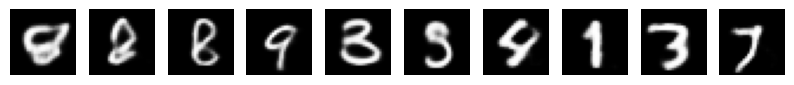

In [26]:
def plot_images(images, n=10):
    plt.figure(figsize=(n, 1.5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Генерируем новые цифры
z_new = np.random.normal(size=(10, LATENT_DIM))
preds = vae.decoder.predict(z_new)
plot_images(preds, n=10)
